In [141]:
import pprint
from keras.utils.data_utils import get_file
from keras.utils import np_utils, Sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Dot, Reshape, Activation, Concatenate, Lambda
from keras import Input
import keras.backend as K

import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds

In [3]:
# path = './alice.txt'
path = "./PrideAndPrejudice.txt"
sentences = [line.strip() for line in open(path) if line != '\n']

sentences = sentences[:5000]

In [5]:
tokenizer = Tokenizer(num_words = 2000)
tokenizer.fit_on_texts(sentences)
corpus = tokenizer.texts_to_sequences(sentences)

V = len(tokenizer.word_index) + 1
dim = 2
window_size = 5

# Skipgram without negative sampling

## Data processing

In [7]:
pair_data, labels = [], []
for words in corpus:
    temp_pair_data, temp_labels = skipgrams(words, V, window_size, negative_samples=0, shuffle=True)
    pair_data += temp_pair_data
    labels += temp_labels
    
pair_data = [[np_utils.to_categorical(ele1, V), \
              np_utils.to_categorical(ele2, V)] \
             for ele1, ele2 in pair_data]

X = np.array([ele[0] for ele in pair_data])
y = np.array([ele[1] for ele in pair_data])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [8]:
X_train.shape

(304038, 4776)

## Build model

In [54]:
model = Sequential()
model.add(Input(shape = V))
model.add(Dense(dim, activation='softmax'))
model.add(Dense(V, activation='softmax'))
model.layers[0]._name = "Hidden_Layer"
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer (Dense)         (None, 2)                 9554      
_________________________________________________________________
dense_5 (Dense)              (None, 4776)              14328     
Total params: 23,882
Trainable params: 23,882
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.fit(X_train, y_train, batch_size = 64, validation_data = (X_test, y_test), epochs = 2)

Epoch 1/2
4751/4751 [==============================] - 27s 6ms/step - loss: 6.3956 - val_loss: 6.0853
Epoch 2/2
4751/4751 [==============================] - 25s 5ms/step - loss: 6.2123 - val_loss: 6.2960


## Check hidden layer result

In [56]:
vectors = model.get_weights()[0]

In [13]:
import matplotlib.pyplot as plt

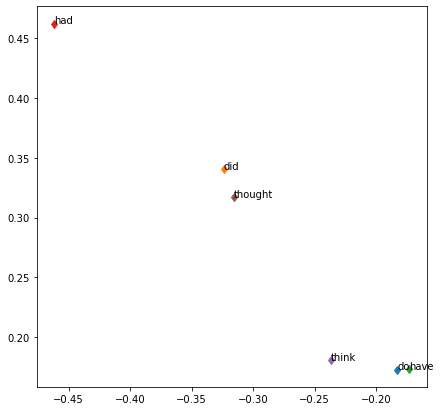

In [59]:
word_lst = ['do','did','have','had', 'think', 'thought']
plt.figure(figsize = (7, 7))
for word in word_lst:
    plt.plot(vectors[tokenizer.word_index[word]][0], \
             vectors[tokenizer.word_index[word]][1], 'd')
    plt.text(vectors[tokenizer.word_index[word]][0], \
             vectors[tokenizer.word_index[word]][1], word)

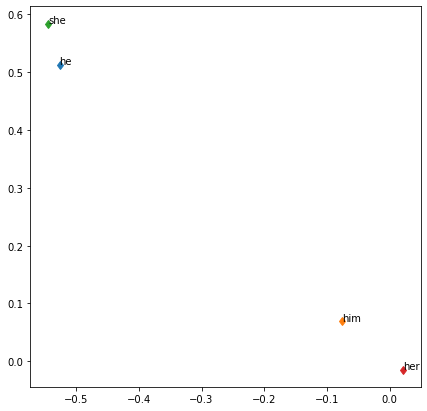

In [57]:
word_lst = ['he', 'him', 'she', 'her']
plt.figure(figsize = (7, 7))

for word in word_lst:
    plt.plot(vectors[tokenizer.word_index[word]][0], \
             vectors[tokenizer.word_index[word]][1], 'd')
    plt.text(vectors[tokenizer.word_index[word]][0], \
             vectors[tokenizer.word_index[word]][1], word)

In this toy example, we used data from "Alice" and trained a model with 2 hidden units. Therefore, we managed to get a vectorization from V = 4776 to dim = 2. From the above plot, we can observe that the model can learn some relation behind the word.

# Skipgram with negative sampling

In [155]:
from keras.layers import Input, Flatten, Embedding, dot, Activation
from tqdm import tqdm

In [137]:
def build_model(input_dim, embedding_dim):
    target_input_token = Input(shape=[1])
    context_input_token = Input(shape=[1])
    
    target_embed = Embedding(output_dim = embedding_dim, \
                             input_dim = input_dim, input_length = 1, \
                             name = "target_embed")(target_input_token)
    context_embed = Embedding(output_dim = embedding_dim, \
                             input_dim = input_dim, input_length = 1, \
                             name = "context_embed")(context_input_token)
    
    target_vec = Flatten()(target_embed)
    context_vec = Flatten()(context_embed)
    
    y = Activation('sigmoid')(dot([target_vec, context_vec], axes = 1))
    model = Model(inputs=[target_input_token, context_input_token], outputs = [y])
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')
    
    return model

In [138]:
model = build_model(V, 10)

In [139]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
target_embed (Embedding)        (None, 1, 10)        47760       input_8[0][0]                    
__________________________________________________________________________________________________
context_embed (Embedding)       (None, 1, 10)        47760       input_9[0][0]                    
____________________________________________________________________________________________

In [156]:
def train_model(model, sentences, num_neg_samples = 30, window_size = 5, epochs = 2, V = V):
    for epoch in range(epochs):
        loss = 0.
        for i, sent in enumerate(tqdm(sentences)):
            couples, labels = skipgrams(sequence=sent, vocabulary_size = V, \
                                        window_size = window_size, \
                                        negative_samples=num_neg_samples)
            if couples:
                words, contexts = zip(*couples)
                words = np.array(words, dtype=np.int32)
                contexts = np.array(contexts, dtype=np.int32)
                y = np.array(labels, dtype=np.int32)
                loss += model.train_on_batch([words, contexts], y)
        print('num epoch: {} loss: {}'.format(epoch, loss))

    return model

In [157]:
train_model(model, corpus)

  0%|          | 9/5000 [00:00<00:55, 89.61it/s]

num epoch: 0 loss: 963.2725164070725


100%|██████████| 5000/5000 [01:35<00:00, 52.51it/s]

num epoch: 1 loss: 618.3400668818504


In [161]:
vectors = model.get_weights()[0]

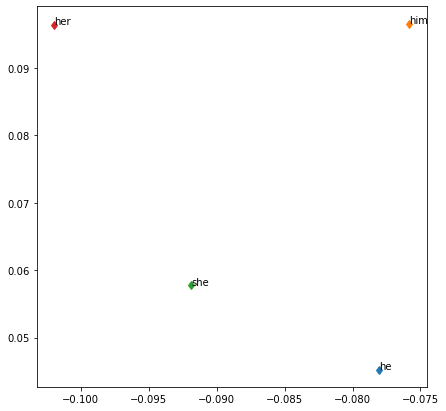

In [162]:
word_lst = ['he', 'him', 'she', 'her']
plt.figure(figsize = (7, 7))

for word in word_lst:
    plt.plot(vectors[tokenizer.word_index[word]][0], \
             vectors[tokenizer.word_index[word]][1], 'd')
    plt.text(vectors[tokenizer.word_index[word]][0], \
             vectors[tokenizer.word_index[word]][1], word)

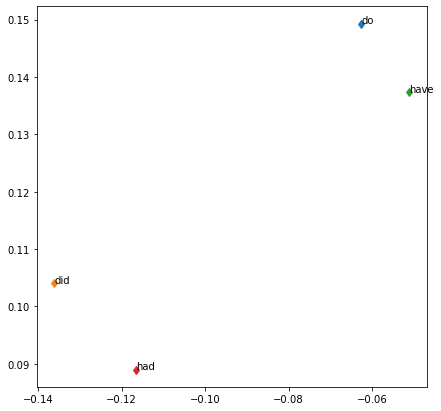

In [164]:
word_lst = ['do','did','have','had']
plt.figure(figsize = (7, 7))
for word in word_lst:
    plt.plot(vectors[tokenizer.word_index[word]][0], \
             vectors[tokenizer.word_index[word]][1], 'd')
    plt.text(vectors[tokenizer.word_index[word]][0], \
             vectors[tokenizer.word_index[word]][1], word)

We can observe some similar result as the previous method.